# Pytorch - MNIST Dataset

Now we will look at a popular computer vision task. The MNIST (Modified National Institute of Standards and Technology) dataset consists of a range of images of handwritten digits and corresponding labels. The task has become a classic task in computer vision.

The read_data_sets function will download the MNIST dataset (55000 training images and 10000 test images) to the working directory. Each image is of resolution 28 pixels * 28 pixels, is grayscale, and looks like one the following images:



In [1]:
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

The following cell will display one training sample (visually) and its corresponding label.

torch.Size([64, 1, 28, 28])
torch.Size([64])


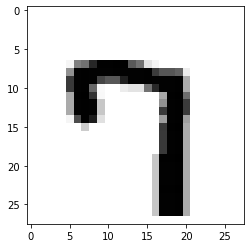

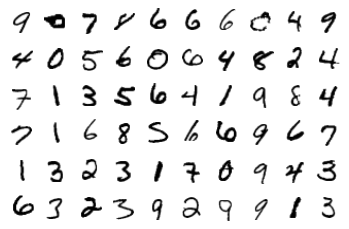

In [2]:
# Define transform
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Loading the training and validation sets
train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

# Iterate dataloader over the training set
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Show a Sample Image in database
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Next, we define some hyperparameters and the model.

In [3]:
# Define the input image size, hidden size, and the output size
input_size = 784 
hidden_sizes = [128, 64]
output_size = 10

# Defining the MLP Model
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In this part, we will define the optimizer and loss function.

In [4]:
# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Iterate data over the training set
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)


Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0047,  0.0047,  0.0047,  ...,  0.0047,  0.0047,  0.0047],
        ...,
        [ 0.0039,  0.0039,  0.0039,  ...,  0.0039,  0.0039,  0.0039],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [-0.0038, -0.0038, -0.0038,  ..., -0.0038, -0.0038, -0.0038]])


So, we start training the model. 

In [5]:
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.675398071556648
Epoch 1 - Training loss: 0.2853264664091281
Epoch 2 - Training loss: 0.22223729974250678
Epoch 3 - Training loss: 0.18049776093212208
Epoch 4 - Training loss: 0.1515461652259678
Epoch 5 - Training loss: 0.12959220727830173
Epoch 6 - Training loss: 0.11309795813468188
Epoch 7 - Training loss: 0.09950399043550814
Epoch 8 - Training loss: 0.08939855476009297
Epoch 9 - Training loss: 0.08047234625674721
Epoch 10 - Training loss: 0.0722429847254404
Epoch 11 - Training loss: 0.06721794023277806
Epoch 12 - Training loss: 0.06136539604302361
Epoch 13 - Training loss: 0.05663570171437546
Epoch 14 - Training loss: 0.05301915878119237

Training Time (in minutes) = 2.205179337660472


After training the model, we can test the performance of the trained model over the training data.

In [6]:
# testing the model by iterating the data over the validation set
images, labels = next(iter(test_loader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
#view_classify(img.view(1, 28, 28), ps)

correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))
# Save the model
torch.save(model, './my_mnist_model.pt') 

Predicted Digit = 2
Number Of Images Tested = 10000

Model Accuracy = 0.9758
